<a href="https://colab.research.google.com/github/Pietrosittoni/Deep_Learning_Based_Gait_Classification/blob/main/Sboarina_Sittoni_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble


In [ ]:
#should add more strada facendo
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import keras
import time
import random
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import random

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Buildin the dataset and index

We take 100 time step for each observation for the joint data:

- from -110 to -10
- We import also thepressure data







In [ ]:
# Dirs is a list with several foilders: subject1,subject2,etc..
path = "/content/drive/MyDrive/Progetto_HDA/HDA_proj_A2"
subject = os.listdir(path)

In [ ]:
response_malattie = {"antalgic":0,"lurching":1,"normal":2,"steppage":3,"stiff-legged":4,"trendelenburg":5}

In [ ]:
mean_dist_before = np.zeros(1440)
std_dist_before = np.zeros(1440)

mean_dist_after = np.zeros(1440)
std_dist_after = np.zeros(1440)

# y-axis-we we will use only the y axis coordinate becasue the path is parallel to the y axis
y_coor = [i for i in range(96) if i%3==1]
window = {}

In [ ]:
subject = ["subject"+str(i) for i in range(1,13)]
trial = ["trial"+str(i) for i in range(1,21)]
control = True
time_window = 100
delay = 1
up = -delay-time_window
down = -delay
obs = 0

for i in subject:
  pathsubject = path+"/"+i
  for j in list(response_malattie.keys()):
    pathmalattia = pathsubject+"/"+j
    for l in trial:
      pathtrial = pathmalattia+"/"+l
      path_ = pathtrial+"/pressure.csv"
      path__ = pathtrial+"/skeleton.csv"
      if control:

        control = False

        full_kinect = pd.read_csv(path__,header=None).to_numpy()[:,1:-1]  # first colums composed by Nan
        DataFramepressure = pd.read_csv(path_,header=None).to_numpy() # import our pressure

        df_kinect = full_kinect[up:down] #primo giro

        Y = np.array([response_malattie[j]]) #response

        # mean distance traveld of the gracity center of the discard data and not
        mean_dist_before[obs] = (abs(full_kinect[0,y_coor]-full_kinect[up,y_coor])+abs(full_kinect[down,y_coor]-full_kinect[-1,y_coor])).mean()


        mean_dist_after[obs] = abs(full_kinect[up,y_coor]-full_kinect[down,y_coor]).mean()

        window[obs] = full_kinect.shape[0]
        obs+=1

        del full_kinect

      elif not control:
        full_kinect = pd.read_csv(path__,header=None).to_numpy()[:,1:-1]
        temp_press = pd.read_csv(path_,header=None).to_numpy()


        DataFramepressure = np.concatenate([DataFramepressure,temp_press])

        df_kinect = np.concatenate([df_kinect,full_kinect[up:down]])


        Y = np.concatenate([Y,np.array([response_malattie[j]])])

        # mean distance traveld of the gracity center of the discard data and not
        mean_dist_before[obs] = (abs(full_kinect[0,y_coor]-full_kinect[up,y_coor])+abs(full_kinect[down,y_coor]-full_kinect[-1,y_coor])).mean()

        mean_dist_after[obs] = abs(full_kinect[up,y_coor]-full_kinect[down,y_coor]).mean()

        window[obs] = full_kinect.shape[0]
        obs+=1


        del full_kinect
        del temp_press

In [ ]:
# Save all the dataset in the drive folder

savepressure = "/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/pressure.csv"
savekinect = "/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/kinect.csv"


pd.DataFrame(df_kinect).to_csv(savekinect)
pd.DataFrame(DataFramepressure).to_csv(savepressure)
np.savetxt("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/y.csv",Y)

np.savetxt("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/mean_dist_before.csv",mean_dist_before)
np.savetxt("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/mean_dist_after.csv",mean_dist_after)
pd.Series(window).to_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/nomber_of_new_obs.csv")

# Import prepared data and pre-select fetures


In [ ]:
columns = ['date',
                           'pelvis_dim1','pelvis_dim2', 'pelvis_dim3',#0,1,2
                           'spine_naval_dim1', 'spine_naval_dim2', 'spine_naval_dim3', #3,4,5
                           'spine_chest_dim1', 'spine_chest_dim2','spine_chest_dim3',#6,7,8
                           'neck_dim1', 'neck_dim2', 'neck_dim3',#9,10,11

                           'clavicle_left_dim1', 'clavicle_left_dim2', 'clavicle_left_dim3',#12,13,14
                           'shoulder_left_dim1', 'shoulder_left_dim2', 'shoulder_left_dim3',#15,16,17
                           'elbow_left_dim1', 'elbow_left_dim2', 'elbow_left_dim3',#18,19,20
                           'wrist_left_dim1', 'wrist_left_dim2', 'wrist_left_dim3',#21,22,23
                           'hand_left_dim1', 'hand_left_dim2', 'hand_left_dim3',#24,25,26
                           'handtip_left_dim1', 'handtip_left_dim2', 'handtip_left_dim3',#27,28,29
                           'thumb_left_dim1', 'thumb_left_dim2', 'thumb_left_dim3',#30,31,32

                           'clavicle_right_dim1', 'clavicle_right_dim2', 'clavicle_right_dim3',#33,34,35
                           'shoulder_right_dim1', 'shoulder_right_dim2', 'shoulder_right_dim3',#36,37,38
                           'elbow_right_dim1', 'elbow_right_dim2', 'elbow_right_dim3',#39,40,41
                           'wrist_right_dim1', 'wrist_right_dim2', 'wrist_right_dim3',#42,43,44
                           'hand_right_dim1', 'hand_right_dim2', 'hand_right_dim3',#45,46,47
                           'handtip_right_dim1', 'handtip_right_dim2', 'handtip_right_dim3',#48,49,50
                           'thumb_right_dim1', 'thumb_right_dim2', 'thumb_right_dim3',#51,52,53

                           'hip_left_dim1', 'hip_left_dim2', 'hip_left_dim3',#54,55,56
                           'knee_left_dim1', 'knee_left_dim2', 'knee_left_dim3',#57,58,59
                           'ankle_left_dim1', 'ankle_left_dim2', 'ankle_left_dim3',#60,61,62
                           'foot_left_dim1', 'foot_left_dim2', 'foot_left_dim3',#63,64,65

                           'hip_right_dim1', 'hip_right_dim2', 'hip_right_dim3',#66,67,68
                           'knee_right_dim1', 'knee_right_dim2', 'knee_right_dim3',#69,70,71
                           'ankle_right_dim1', 'ankle_right_dim2', 'ankle_right_dim3',#72,73,74
                           'foot_right_dim1', 'foot_right_dim2', 'foot_right_dim3',#75,76,77

                           'head_dim1', 'head_dim2', 'head_dim3',#78,79,80
                           'nose_dim1', 'nose_dim2', 'nose_dim3',#81,82,83

                           'eye_left_dim1', 'eye_left_dim2', 'eye_left_dim3',#84,85,86
                           'ear_left_dim1',  'ear_left_dim2',  'ear_left_dim3',#87,88,89

                           'eye_right_dim1', 'eye_right_dim2', 'eye_right_dim3',#90,91,92
                           'eye_right_dim1',  'eye_right_dim2',  'eye_right_dim3']#93,94,95

left1 = [i for i in range(12,33)]
left2 = [i for i in range(54,66)]
left3 = [i for i in range(84,90)]

mid = [i for i in range(12)]+[i for i in range(78,84)]

right1 = [i for i in range(33,54)]
right2 = [i for i in range(66,78)]
right3 = [i for i in range(90,96)]


joints = [0,1,2,3,4,5,6,7,8,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77]
joints_leg = [54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77]
joints_left_right = left1 + left2 + left3 + right1 + right2 + right3
response_malattie = {"antalgic":1,"lurching":2,"normal":3,"steppage":4,"stiff-legged":5,"trendelenburg":6}

In [ ]:
kinect = pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/kinect.csv").to_numpy()[:,1:]

Y = pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/y.csv",header=None).to_numpy()
Y = np.array([i.item() for i in Y])

mean_dist_before = pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/mean_dist_before.csv",header=None).to_numpy()
mean_dist_before = np.array([i.item() for i in mean_dist_before])
mean_dist_after = pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/mean_dist_after.csv",header=None).to_numpy()
mean_dist_after = np.array([i.item() for i in mean_dist_after])

pressure = pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/pressure.csv").to_numpy()[:,1:].reshape((1440,128,48)) # bisogna aggiustare il codice buildn the dataset, farò più avanti

obs = int(kinect.shape[0]/100)

kinect = kinect.reshape((obs,100,96))

windwos = dict(zip([i[0] for i in pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/nomber_of_new_obs.csv").values],[i[1] for i in pd.read_csv("/content/drive/MyDrive/Progetto_HDA/prepared_dataset2/nomber_of_new_obs.csv").values]))

Y = np.array([i.item() for i in Y])

# Data augmentation

We swap the left and right in order to double the data

In [ ]:
#defining left and right for all the dimension

In [ ]:
left1 = [i for i in range(12,33)]
left2 = [i for i in range(54,66)]
left3 = [i for i in range(84,90)]

mid = [i for i in range(12)]+[i for i in range(78,84)]

right1 = [i for i in range(33,54)]
right2 = [i for i in range(66,78)]
right3 = [i for i in range(90,96)]

In [ ]:
#increasing size of arrays "kinect_aument," "pressure_aument," and "Y_aument" duplicating and reorganizing the values from the original arrays.

In [ ]:
kinect_aument = np.zeros((2*kinect.shape[0],100,96))
pressure_aument = np.zeros((2*kinect.shape[0],128,48))

Y_aument = np.zeros((2*kinect.shape[0]))

for i in range(2*kinect.shape[0]):
  if i%2==0:
    kinect_aument[i] = kinect[i//2]
    pressure_aument[i] = pressure[i//2]
    Y_aument[i] = Y[i//2]

  if i%2==1:
    kinect_aument[i,:,left1],  kinect_aument[i,:,left2],  kinect_aument[i,:,left3],  kinect_aument[i,:,right1],  kinect_aument[i,:,right2],  kinect_aument[i,:,right3] = kinect[i//2,:,right1],  kinect[i//2,:,right2],  kinect[i//2,:,right3],  kinect[i//2,:,left1],  kinect[i//2,:,left2],  kinect[i//2,:,left3]
    pressure_aument[i] = np.flip(pressure[i//2],axis=1)
    Y_aument[i] = Y[i//2]


# EDA
* Mean walk length
* Time length


In [ ]:
print("==================================== Path length =====================================\n")
print(f"Min lenght: {min(windwos.values())}")
print(f"Min lenght: {max(windwos.values())}")
print(f"Mean lenght: {sum(windwos.values())/len(windwos.values())}")
print("======================================================================================")
print("\n")

n = len(windwos.values())

print("======================== Distance covered (discard and keep)  ========================\n")
print("The mean distance of y coordinate discarded by the subjects is:\n")

print(f"How much distance is coverd: {mean_dist_before.mean()}")
print("\n")

print("The mean distance of y coordinate stored by the subjects is:\n")

print(f"How much distance is coverd: {mean_dist_after.mean()}")
print("======================================================================================")

==================================== Path length =====================================

Min lenght: 118
Min lenght: 509
Mean lenght: 220.38888888888889


======================== Distance covered (discard and keep)  ========================

The mean distance of y coordinate discarded by the subjects is:

How much distance is coverd: 0.45851986171875


The mean distance of y coordinate stored by the subjects is:

How much distance is coverd: 2.0926598292751737


# Train/val/test-split

Subject Hold-out: randomly select 1 patient and half as test and 1 patient and half as validation.
Standard scaler for the joints data, minmax scaler for the pressure data

In [ ]:
index_patient = [[j for j in range(i*240,(i+1)*240)] for i in range(12)]

In [ ]:
######## train/val/test-split

np.random.seed(1635)
id_patient = np.array([i for i in range(12)])
np.random.shuffle(id_patient)
print(f"Validation patient: id {id_patient[0]}, and even observation {id_patient[1]}")
print(f"Test patient: id {id_patient[2]}, and odd observation {id_patient[1]}")
print(f"Train patients: id {id_patient[3:]}")



index_train = index_patient[id_patient[3]]+index_patient[id_patient[4]]+index_patient[id_patient[5]]+index_patient[id_patient[6]]+index_patient[id_patient[7]]+index_patient[id_patient[8]]+index_patient[id_patient[9]]+index_patient[id_patient[10]]+index_patient[id_patient[11]]
index_test = index_patient[id_patient[0]]+list(np.array(index_patient[id_patient[1]])[[i for i in range(240) if i%2==0]])
index_val = index_patient[id_patient[2]]+list(np.array(index_patient[id_patient[1]])[[i for i in range(240) if i%2==1]])


X_train = kinect_aument[index_train]
X_val = kinect_aument[index_val]
X_test = kinect_aument[index_test]

X_train_pres = pressure_aument[index_train]
X_val_pres = pressure_aument[index_val]
X_test_pres = pressure_aument[index_test]

Y_train = Y_aument[index_train]
Y_val = Y_aument[index_val]
Y_test = Y_aument[index_test]


Y_train = tf.one_hot(Y_train,depth=6)
Y_val = tf.one_hot(Y_val,depth=6)
Y_test = tf.one_hot(Y_test,depth=6)

Validation patient: id 1, and even observation 3
Test patient: id 10, and odd observation 3
Train patients: id [ 5  9  7  6  2 11  0  8  4]


In [ ]:
# MinMaxScaler and Standard scaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train_pres.reshape(X_train_pres.shape[0]*X_train_pres.shape[1],X_train_pres.shape[2]))

X_train_pres = scaler.transform(X_train_pres.reshape(X_train_pres.shape[0]*X_train_pres.shape[1],X_train_pres.shape[2])).reshape(X_train_pres.shape[0],X_train_pres.shape[1],X_train_pres.shape[2])
X_val_pres = scaler.transform(X_val_pres.reshape(X_val_pres.shape[0]*X_val_pres.shape[1],X_val_pres.shape[2])).reshape(X_val_pres.shape[0],X_val_pres.shape[1],X_val_pres.shape[2])
X_test_pres = scaler.transform(X_test_pres.reshape(X_test_pres.shape[0]*X_test_pres.shape[1],X_test_pres.shape[2])).reshape(X_test_pres.shape[0],X_test_pres.shape[1],X_test_pres.shape[2])

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2]))

X_train = scaler.transform(X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2])).reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2])
X_val = scaler.transform(X_val.reshape(X_val.shape[0]*X_val.shape[1],X_val.shape[2])).reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2])
X_test = scaler.transform(X_test.reshape(X_test.shape[0]*X_test.shape[1],X_test.shape[2])).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

In [ ]:
train_time = []
acc_hist_val = []
acc_hist_test = []

In [ ]:
# We save the test set!
np.save("/content/drive/MyDrive/Progetto_HDA/test_set.npy",X_test)
np.save("/content/drive/MyDrive/Progetto_HDA/y_test_set.npy",Y_test)

# All fetures

* LSTM
* GRU
* Hybrid pressuser+kinect


## LSTM


In [ ]:
tf.random.set_seed(4)
np.random.seed(23)
random.seed(23)

In [ ]:
#building the LSTM RNN

In [ ]:
class classifier_lstm(Model):
  def __init__(self):
    super(classifier_lstm, self).__init__()
    self.input_ = 96
    self.rec =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
          ])

    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_lstm_all = classifier_lstm()

In [ ]:
model_lstm_all.rec.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, None, 256)         361472    
                                                                 
 lstm_65 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_66 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_67 (LSTM)              (None, 128)               131584    
                                                                 
Total params: 1,215,488
Trainable params: 1,215,488
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_all(X_train[1:3,:,:])
model_lstm_all.ffnn.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_84 (Bat  (2, 128)                 512       
 chNormalization)                                                
                                                                 
 activation_84 (Activation)  (2, 128)                  0         
                                                                 
 dense_106 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_85 (Bat  (2, 64)                  256       
 chNormalization)                                                
                                                                 
 activation_85 (Activation)  (2, 64)                 

In [ ]:
#training the LSTM NN for all features

In [ ]:
model_lstm_all.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=40)

time_start = time.time()

history_class_mod = model_lstm_all.fit(X_train[:,:,:], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,:], Y_val),callbacks=[es])


end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 9s 47ms/step - loss: 1.7602 - accuracy: 0.1903 - val_loss: 1.5156 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 24ms/step - loss: 1.5156 - accuracy: 0.2458 - val_loss: 1.5019 - val_accuracy: 0.1750
Epoch 3/200
72/72 [==============================] - 2s 25ms/step - loss: 1.3562 - accuracy: 0.2995 - val_loss: 1.3870 - val_accuracy: 0.2389
Epoch 4/200
72/72 [==============================] - 2s 26ms/step - loss: 1.2231 - accuracy: 0.3713 - val_loss: 1.2982 - val_accuracy: 0.2944
Epoch 5/200
72/72 [==============================] - 2s 25ms/step - loss: 1.0961 - accuracy: 0.4495 - val_loss: 1.1138 - val_accuracy: 0.4806
Epoch 6/200
72/72 [==============================] - 2s 24ms/step - loss: 1.0149 - accuracy: 0.5088 - val_loss: 0.9924 - val_accuracy: 0.5917
Epoch 7/200
72/72 [==============================] - 2s 24ms/step - loss: 0.9319 - accuracy: 0.5880 - val_loss: 0.9457 - val_accuracy: 0.5778
Epoch 

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_lstm_all.predict(X_test[:,:,:]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_lstm_all.predict(X_val[:,:,:]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 14ms/step
Accuracy validation: 0.8861111111111111


## GRU

In [ ]:
tf.random.set_seed(33)
np.random.seed(23)
random.seed(23)

In [ ]:
#building the GRU RNN model

In [ ]:
class classifier_gru(Model):
  def __init__(self):
    super(classifier_gru, self).__init__()
    self.input_ = 96
    self.rec =  tf.keras.Sequential([
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
                           ])

    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_gru_all = classifier_gru()

In [ ]:
model_gru_all.rec.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, None, 256)         271872    
                                                                 
 gru_21 (GRU)                (None, None, 256)         394752    
                                                                 
 gru_22 (GRU)                (None, None, 128)         148224    
                                                                 
 gru_23 (GRU)                (None, 128)               99072     
                                                                 
Total params: 913,920
Trainable params: 913,920
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru_all(X_train[1:3,:,:])
model_gru_all.ffnn.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_88 (Bat  (2, 128)                 512       
 chNormalization)                                                
                                                                 
 activation_88 (Activation)  (2, 128)                  0         
                                                                 
 dense_111 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_89 (Bat  (2, 64)                  256       
 chNormalization)                                                
                                                                 
 activation_89 (Activation)  (2, 64)                 

In [ ]:
#training the GRU RNN model for "all features"

In [ ]:
model_gru_all.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()
history_class_mod = model_gru_all.fit(X_train[:,:,:], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,:], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 9s 43ms/step - loss: 1.8916 - accuracy: 0.1718 - val_loss: 1.5017 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 22ms/step - loss: 1.8039 - accuracy: 0.1662 - val_loss: 1.4871 - val_accuracy: 0.2361
Epoch 3/200
72/72 [==============================] - 2s 22ms/step - loss: 1.7142 - accuracy: 0.1745 - val_loss: 1.4787 - val_accuracy: 0.2583
Epoch 4/200
72/72 [==============================] - 2s 22ms/step - loss: 1.6111 - accuracy: 0.2005 - val_loss: 1.4369 - val_accuracy: 0.2139
Epoch 5/200
72/72 [==============================] - 2s 23ms/step - loss: 1.5451 - accuracy: 0.2287 - val_loss: 1.3178 - val_accuracy: 0.1833
Epoch 6/200
72/72 [==============================] - 2s 25ms/step - loss: 1.4757 - accuracy: 0.2639 - val_loss: 1.3548 - val_accuracy: 0.2083
Epoch 7/200
72/72 [==============================] - 2s 23ms/step - loss: 1.4095 - accuracy: 0.2833 - val_loss: 1.3643 - val_accuracy: 0.3111
Epoch 

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_gru_all.predict(X_test[:,:,:]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_gru_all.predict(X_val[:,:,:]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 12ms/step
Accuracy validation: 0.8916666666666667


## Hybrid-LSTM


In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#building the Hybrid-LSTM CNN RNN model

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=96, return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=96, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=96, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=96, return_sequences=False,dropout=0.5),
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_lstm_all=fuse()

In [ ]:
model_hy_lstm_all.cnn.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 24, 128)       1280      
                                                                 
 activation_92 (Activation)  (None, 64, 24, 128)       0         
                                                                 
 average_pooling2d (AverageP  (None, 32, 24, 128)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 12, 64)        73792     
                                                                 
 activation_93 (Activation)  (None, 16, 12, 64)        0         
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 6, 64)         0         
 ePooling2D)                                         

In [ ]:
#training the Hybrid-LSTM CNN RNN model for "all features

In [ ]:
model_hy_lstm_all.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_lstm_all.fit([X_train_pres,X_train], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)



Epoch 1/200
72/72 [==============================] - 16s 67ms/step - loss: 1.6863 - accuracy: 0.1833 - val_loss: 1.5475 - val_accuracy: 0.1556
Epoch 2/200
72/72 [==============================] - 2s 30ms/step - loss: 1.4830 - accuracy: 0.2694 - val_loss: 1.6158 - val_accuracy: 0.1667
Epoch 3/200
72/72 [==============================] - 2s 29ms/step - loss: 1.3008 - accuracy: 0.3690 - val_loss: 1.6383 - val_accuracy: 0.1778
Epoch 4/200
72/72 [==============================] - 2s 29ms/step - loss: 1.1847 - accuracy: 0.4477 - val_loss: 1.5714 - val_accuracy: 0.3250
Epoch 5/200
72/72 [==============================] - 2s 28ms/step - loss: 1.0761 - accuracy: 0.5042 - val_loss: 1.4136 - val_accuracy: 0.3056
Epoch 6/200
72/72 [==============================] - 2s 29ms/step - loss: 0.9938 - accuracy: 0.5727 - val_loss: 1.2035 - val_accuracy: 0.4944
Epoch 7/200
72/72 [==============================] - 2s 35ms/step - loss: 0.9200 - accuracy: 0.6074 - val_loss: 1.1135 - val_accuracy: 0.4778
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_lstm_all.predict([X_test_pres,X_test]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_lstm_all.predict([X_val_pres,X_val]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 10ms/step
Accuracy validation: 0.775


## Hybrid-GRU


In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#building the Hybrid-GRU CNN RNN model

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.GRU(256,input_dim=96, return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=96, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=96, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=96, return_sequences=False,dropout=0.5),
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_gru_all=fuse()

In [ ]:
model_hy_gru_all.cnn.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 24, 128)       1280      
                                                                 
 activation_103 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_3 (Averag  (None, 32, 24, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 12, 64)        73792     
                                                                 
 activation_104 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_4 (Averag  (None, 8, 6, 64)         0         
 ePooling2D)                                         

In [ ]:
#Training the Hybrid-GRU CNN RNN model on "all features"

In [ ]:
model_hy_gru_all.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()
history_class_mod = model_hy_gru_all.fit([X_train_pres,X_train], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 12s 53ms/step - loss: 1.7060 - accuracy: 0.1778 - val_loss: 1.5340 - val_accuracy: 0.1361
Epoch 2/200
72/72 [==============================] - 2s 26ms/step - loss: 1.5880 - accuracy: 0.2194 - val_loss: 1.5517 - val_accuracy: 0.1639
Epoch 3/200
72/72 [==============================] - 2s 26ms/step - loss: 1.4908 - accuracy: 0.2528 - val_loss: 1.5113 - val_accuracy: 0.1833
Epoch 4/200
72/72 [==============================] - 2s 26ms/step - loss: 1.4060 - accuracy: 0.2931 - val_loss: 1.4851 - val_accuracy: 0.1861
Epoch 5/200
72/72 [==============================] - 2s 26ms/step - loss: 1.3225 - accuracy: 0.3602 - val_loss: 1.4522 - val_accuracy: 0.1944
Epoch 6/200
72/72 [==============================] - 2s 28ms/step - loss: 1.2465 - accuracy: 0.4065 - val_loss: 1.4657 - val_accuracy: 0.1833
Epoch 7/200
72/72 [==============================] - 2s 31ms/step - loss: 1.1733 - accuracy: 0.4491 - val_loss: 1.3277 - val_accuracy: 0.3472
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_gru_all.predict([X_test_pres,X_test]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_gru_all.predict([X_val_pres,X_val]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 11ms/step
Accuracy validation: 0.7861111111111111


# Sub1

* LSTM
* GRU
* Hybrid pressuser+kinect


In [ ]:
features = joints

## LSTM

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#building LST RNN model for Sub1

In [ ]:
class classifier_lstm(Model):
  def __init__(self):
    super(classifier_lstm, self).__init__()
    self.input_ = len(features)
    self.rec =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
          ])

    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_lstm_sub1 = classifier_lstm()

In [ ]:
model_lstm_sub1.rec.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, None, 256)         296960    
                                                                 
 lstm_73 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_74 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_75 (LSTM)              (None, 128)               131584    
                                                                 
Total params: 1,150,976
Trainable params: 1,150,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_sub1(X_train[1:3,:,features])
model_lstm_sub1.ffnn.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_108 (Ba  (2, 128)                 512       
 tchNormalization)                                               
                                                                 
 activation_114 (Activation)  (2, 128)                 0         
                                                                 
 dense_134 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_109 (Ba  (2, 64)                  256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (2, 64)                

In [ ]:
#training LST RNN model on Sub1

In [ ]:
model_lstm_sub1.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()
history_class_mod = model_lstm_sub1.fit(X_train[:,:,features], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,features], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 9s 46ms/step - loss: 1.7417 - accuracy: 0.1861 - val_loss: 1.5050 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 23ms/step - loss: 1.4677 - accuracy: 0.2523 - val_loss: 1.4813 - val_accuracy: 0.1667
Epoch 3/200
72/72 [==============================] - 2s 23ms/step - loss: 1.2817 - accuracy: 0.3222 - val_loss: 1.3777 - val_accuracy: 0.2222
Epoch 4/200
72/72 [==============================] - 2s 23ms/step - loss: 1.1538 - accuracy: 0.3843 - val_loss: 1.2040 - val_accuracy: 0.4222
Epoch 5/200
72/72 [==============================] - 2s 23ms/step - loss: 1.0641 - accuracy: 0.4630 - val_loss: 1.0943 - val_accuracy: 0.4889
Epoch 6/200
72/72 [==============================] - 2s 24ms/step - loss: 0.9938 - accuracy: 0.5102 - val_loss: 0.9196 - val_accuracy: 0.6278
Epoch 7/200
72/72 [==============================] - 2s 26ms/step - loss: 0.9217 - accuracy: 0.5569 - val_loss: 0.8220 - val_accuracy: 0.6333
Epoch 

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_lstm_sub1.predict(X_test[:,:,features]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_lstm_sub1.predict(X_val[:,:,features]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 12ms/step
Accuracy validation: 0.7888888888888889


## GRU

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#building GRU RNN for "sub1"

In [ ]:
class classifier_gru(Model):
  def __init__(self):
    super(classifier_gru, self).__init__()
    self.input_ = len(features)
    self.rec =  tf.keras.Sequential([
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
            ])


    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_gru_sub1 = classifier_gru()

In [ ]:
model_gru_sub1.rec.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, None, 256)         223488    
                                                                 
 gru_29 (GRU)                (None, None, 256)         394752    
                                                                 
 gru_30 (GRU)                (None, None, 128)         148224    
                                                                 
 gru_31 (GRU)                (None, 128)               99072     
                                                                 
Total params: 865,536
Trainable params: 865,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru_sub1(X_train[1:3,:,features])
model_gru_sub1.ffnn.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_112 (Ba  (2, 128)                 512       
 tchNormalization)                                               
                                                                 
 activation_118 (Activation)  (2, 128)                 0         
                                                                 
 dense_139 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_113 (Ba  (2, 64)                  256       
 tchNormalization)                                               
                                                                 
 activation_119 (Activation)  (2, 64)                

In [ ]:
#Training the GRU RNN on "sub1"

In [ ]:
model_gru_sub1.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_gru_sub1.fit(X_train[:,:,features], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,features], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 10s 55ms/step - loss: 1.9154 - accuracy: 0.1676 - val_loss: 1.4896 - val_accuracy: 0.1694
Epoch 2/200
72/72 [==============================] - 2s 22ms/step - loss: 1.7938 - accuracy: 0.1630 - val_loss: 1.4531 - val_accuracy: 0.2111
Epoch 3/200
72/72 [==============================] - 1s 21ms/step - loss: 1.7056 - accuracy: 0.1759 - val_loss: 1.3889 - val_accuracy: 0.2306
Epoch 4/200
72/72 [==============================] - 2s 22ms/step - loss: 1.5926 - accuracy: 0.2287 - val_loss: 1.3571 - val_accuracy: 0.3583
Epoch 5/200
72/72 [==============================] - 2s 23ms/step - loss: 1.5048 - accuracy: 0.2458 - val_loss: 1.2708 - val_accuracy: 0.2944
Epoch 6/200
72/72 [==============================] - 2s 24ms/step - loss: 1.4506 - accuracy: 0.2565 - val_loss: 1.3281 - val_accuracy: 0.3194
Epoch 7/200
72/72 [==============================] - 2s 21ms/step - loss: 1.4081 - accuracy: 0.2912 - val_loss: 1.1521 - val_accuracy: 0.3278
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_gru_sub1.predict(X_test[:,:,features]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_gru_sub1.predict(X_val[:,:,features]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 11ms/step
Accuracy validation: 0.7333333333333333


## Hybrid-LSTM


In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#Building the Hybrid-LSTM RNN model for "Sub1"

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=len(features), return_sequences=False,dropout=0.5),
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_lstm_sub1=fuse()

In [ ]:
model_hy_lstm_sub1.cnn.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 24, 128)       1280      
                                                                 
 activation_122 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_6 (Averag  (None, 32, 24, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 12, 64)        73792     
                                                                 
 activation_123 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_7 (Averag  (None, 8, 6, 64)         0         
 ePooling2D)                                         

In [ ]:
#Training the Hybrid-LSTM RNN model on "Sub1"

In [ ]:
model_hy_lstm_sub1.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_lstm_sub1.fit([X_train_pres,X_train[:,:,features]], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val[:,:,features]], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 11s 64ms/step - loss: 1.6418 - accuracy: 0.1963 - val_loss: 1.5448 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 30ms/step - loss: 1.4580 - accuracy: 0.2528 - val_loss: 1.5828 - val_accuracy: 0.1389
Epoch 3/200
72/72 [==============================] - 2s 27ms/step - loss: 1.3169 - accuracy: 0.3556 - val_loss: 1.5431 - val_accuracy: 0.2000
Epoch 4/200
72/72 [==============================] - 2s 27ms/step - loss: 1.2059 - accuracy: 0.4324 - val_loss: 1.5017 - val_accuracy: 0.2389
Epoch 5/200
72/72 [==============================] - 2s 27ms/step - loss: 1.0916 - accuracy: 0.5185 - val_loss: 1.3269 - val_accuracy: 0.3722
Epoch 6/200
72/72 [==============================] - 2s 28ms/step - loss: 1.0121 - accuracy: 0.5620 - val_loss: 1.2056 - val_accuracy: 0.4000
Epoch 7/200
72/72 [==============================] - 2s 30ms/step - loss: 0.9411 - accuracy: 0.6032 - val_loss: 1.0292 - val_accuracy: 0.4889
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_lstm_sub1.predict([X_test_pres,X_test[:,:,features]]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_lstm_sub1.predict([X_val_pres,X_val[:,:,features]]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 11ms/step
Accuracy validation: 0.7277777777777777


## Hybrid-GRU


In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#Building the Hybrid-GRU Model for "Sub1"

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.GRU(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=len(features), return_sequences=False,dropout=0.5),
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_gru_sub1=fuse()

In [ ]:
model_hy_gru_sub1.cnn.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 24, 128)       1280      
                                                                 
 activation_133 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_9 (Averag  (None, 32, 24, 128)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 12, 64)        73792     
                                                                 
 activation_134 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_10 (Avera  (None, 8, 6, 64)         0         
 gePooling2D)                                        

In [ ]:
#Training the Hybrid-GRU Model on "Sub1"

In [ ]:
model_hy_gru_sub1.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_gru_sub1.fit([X_train_pres,X_train[:,:,features]], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val[:,:,features]], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 10s 62ms/step - loss: 1.7087 - accuracy: 0.1787 - val_loss: 1.5289 - val_accuracy: 0.1167
Epoch 2/200
72/72 [==============================] - 2s 27ms/step - loss: 1.5732 - accuracy: 0.2282 - val_loss: 1.5487 - val_accuracy: 0.1583
Epoch 3/200
72/72 [==============================] - 2s 25ms/step - loss: 1.4628 - accuracy: 0.2560 - val_loss: 1.5406 - val_accuracy: 0.1833
Epoch 4/200
72/72 [==============================] - 2s 25ms/step - loss: 1.3850 - accuracy: 0.2972 - val_loss: 1.4645 - val_accuracy: 0.2444
Epoch 5/200
72/72 [==============================] - 2s 25ms/step - loss: 1.3072 - accuracy: 0.3653 - val_loss: 1.4284 - val_accuracy: 0.2611
Epoch 6/200
72/72 [==============================] - 2s 26ms/step - loss: 1.2347 - accuracy: 0.4125 - val_loss: 1.3315 - val_accuracy: 0.3611
Epoch 7/200
72/72 [==============================] - 2s 26ms/step - loss: 1.1564 - accuracy: 0.4611 - val_loss: 1.3077 - val_accuracy: 0.2972
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_gru_sub1.predict([X_test_pres,X_test[:,:,features]]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_gru_sub1.predict([X_val_pres,X_val[:,:,features]]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 11ms/step
Accuracy validation: 0.6527777777777778


# Left & Right

* LSTM
* GRU
* Hybrid pressuser+kinect


In [ ]:
features = joints_left_right

## LSTM

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#building the LSTM RNN for "Left & Right"

In [ ]:
class classifier_lstm(Model):
  def __init__(self):
    super(classifier_lstm, self).__init__()
    self.input_ = len(features)
    self.rec =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
          ])

    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_lstm_ler = classifier_lstm()

In [ ]:
model_lstm_ler.rec.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, None, 256)         343040    
                                                                 
 lstm_81 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_82 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_83 (LSTM)              (None, 128)               131584    
                                                                 
Total params: 1,197,056
Trainable params: 1,197,056
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_ler(X_train[1:3,:,features])
model_lstm_ler.ffnn.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_161 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_132 (Ba  (2, 128)                 512       
 tchNormalization)                                               
                                                                 
 activation_144 (Activation)  (2, 128)                 0         
                                                                 
 dense_162 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_133 (Ba  (2, 64)                  256       
 tchNormalization)                                               
                                                                 
 activation_145 (Activation)  (2, 64)                

In [ ]:
#Training the LSTM RNN on "Left & Right"

In [ ]:
model_lstm_ler.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()
history_class_mod = model_lstm_ler.fit(X_train[:,:,features], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,features], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 11s 46ms/step - loss: 1.7283 - accuracy: 0.1866 - val_loss: 1.4838 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 23ms/step - loss: 1.4701 - accuracy: 0.2542 - val_loss: 1.4358 - val_accuracy: 0.1694
Epoch 3/200
72/72 [==============================] - 2s 24ms/step - loss: 1.2794 - accuracy: 0.3398 - val_loss: 1.3281 - val_accuracy: 0.2333
Epoch 4/200
72/72 [==============================] - 2s 26ms/step - loss: 1.1261 - accuracy: 0.4181 - val_loss: 1.0927 - val_accuracy: 0.4472
Epoch 5/200
72/72 [==============================] - 2s 25ms/step - loss: 1.0184 - accuracy: 0.4819 - val_loss: 0.9393 - val_accuracy: 0.4917
Epoch 6/200
72/72 [==============================] - 2s 23ms/step - loss: 0.9476 - accuracy: 0.5481 - val_loss: 0.7946 - val_accuracy: 0.5889
Epoch 7/200
72/72 [==============================] - 2s 23ms/step - loss: 0.8620 - accuracy: 0.6389 - val_loss: 0.7494 - val_accuracy: 0.6111
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_lstm_ler.predict(X_test[:,:,features]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_lstm_ler.predict(X_val[:,:,features]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 9ms/step
Accuracy validation: 0.9083333333333333


In [ ]:
#predicting on test set

====================== Test set accuracy ======================
0.9333333333333333
================== Test set Confusion Matrix ==================



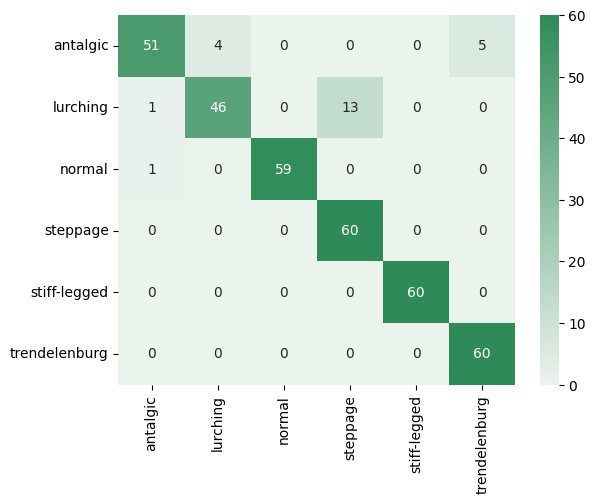

In [ ]:
print("====================== Test set accuracy ======================")
print(acc_test)
print("================== Test set Confusion Matrix ==================\n")
print
cf_matrix = confusion_matrix(y_true, pred)
categories = list(response_malattie.keys())

sns.heatmap(cf_matrix, annot=True,
            xticklabels = categories,
            yticklabels = categories,
            cmap=sns.light_palette("seagreen", as_cmap=True))
plt.show()

In [ ]:
model_lstm_ler.save("/content/drive/MyDrive/Progetto_HDA/models/model_lstm_ler")

## GRU

In [ ]:
#building the GRU RNN for "Left & Right"

In [ ]:
tf.random.set_seed(3432)
np.random.seed(38)
random.seed(23)

In [ ]:
class classifier_gru(Model):
  def __init__(self):
    super(classifier_gru, self).__init__()
    self.input_ = len(features)
    self.rec =  tf.keras.Sequential([
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.0),
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=False,dropout=0.5),

            ])


    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_gru_ler = classifier_gru()

In [ ]:
model_gru_ler.rec.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_28 (GRU)                (None, None, 256)         258048    
                                                                 
 gru_29 (GRU)                (None, None, 256)         394752    
                                                                 
 gru_30 (GRU)                (None, None, 128)         148224    
                                                                 
 gru_31 (GRU)                (None, 128)               99072     
                                                                 
Total params: 900,096
Trainable params: 900,096
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru_ler(X_train[1:3,:,features])
model_gru_ler.ffnn.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (2, 128)                  16384     
                                                                 
 batch_normalization_28 (Bat  (2, 128)                 512       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (2, 128)                  0         
                                                                 
 dense_36 (Dense)            (2, 64)                   8192      
                                                                 
 batch_normalization_29 (Bat  (2, 64)                  256       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (2, 64)                 

In [ ]:
#Training the GRU RNN on "Left & Right"

In [ ]:
model_gru_ler.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_gru_ler.fit(X_train[:,:,features], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,features], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 9s 52ms/step - loss: 1.8804 - accuracy: 0.1648 - val_loss: 1.5136 - val_accuracy: 0.1694
Epoch 2/200
72/72 [==============================] - 2s 22ms/step - loss: 1.7224 - accuracy: 0.1954 - val_loss: 1.4892 - val_accuracy: 0.2528
Epoch 3/200
72/72 [==============================] - 2s 22ms/step - loss: 1.6298 - accuracy: 0.2023 - val_loss: 1.4000 - val_accuracy: 0.2972
Epoch 4/200
72/72 [==============================] - 2s 23ms/step - loss: 1.5144 - accuracy: 0.2500 - val_loss: 1.3194 - val_accuracy: 0.3333
Epoch 5/200
72/72 [==============================] - 2s 22ms/step - loss: 1.4554 - accuracy: 0.2769 - val_loss: 1.2378 - val_accuracy: 0.3139
Epoch 6/200
72/72 [==============================] - 2s 23ms/step - loss: 1.3973 - accuracy: 0.2963 - val_loss: 1.2184 - val_accuracy: 0.3611
Epoch 7/200
72/72 [==============================] - 2s 23ms/step - loss: 1.3250 - accuracy: 0.3181 - val_loss: 1.1195 - val_accuracy: 0.4389
Epoch 

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_gru_ler.predict(X_test[:,:,features]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_gru_ler.predict(X_val[:,:,features]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 11ms/step
Accuracy validation: 0.9


## Hybrid-LSTM


In [ ]:
#building the Hybrid-LSTM RNN CNN for "Left & Right"

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=len(features), return_sequences=False,dropout=0.5),

    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_lstm_ler=fuse()

In [ ]:
model_hy_lstm_ler.cnn.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 24, 128)       1280      
                                                                 
 activation_152 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_12 (Avera  (None, 32, 24, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 12, 64)        73792     
                                                                 
 activation_153 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_13 (Avera  (None, 8, 6, 64)         0         
 gePooling2D)                                        

In [ ]:
#Training the Hybrid-LSTM RNN CNN on "Left & Right"

In [ ]:
model_hy_lstm_ler.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_lstm_ler.fit([X_train_pres,X_train[:,:,features]], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val[:,:,features]], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 11s 54ms/step - loss: 1.6239 - accuracy: 0.2208 - val_loss: 1.5497 - val_accuracy: 0.0861
Epoch 2/200
72/72 [==============================] - 2s 28ms/step - loss: 1.4304 - accuracy: 0.3157 - val_loss: 1.5800 - val_accuracy: 0.0417
Epoch 3/200
72/72 [==============================] - 2s 28ms/step - loss: 1.2929 - accuracy: 0.3829 - val_loss: 1.5637 - val_accuracy: 0.0889
Epoch 4/200
72/72 [==============================] - 2s 34ms/step - loss: 1.1614 - accuracy: 0.4681 - val_loss: 1.4656 - val_accuracy: 0.2306
Epoch 5/200
72/72 [==============================] - 2s 31ms/step - loss: 1.0733 - accuracy: 0.5171 - val_loss: 1.3092 - val_accuracy: 0.4278
Epoch 6/200
72/72 [==============================] - 2s 28ms/step - loss: 0.9858 - accuracy: 0.5690 - val_loss: 1.2135 - val_accuracy: 0.3722
Epoch 7/200
72/72 [==============================] - 2s 28ms/step - loss: 0.8986 - accuracy: 0.6144 - val_loss: 1.0422 - val_accuracy: 0.4667
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_lstm_ler.predict([X_test_pres,X_test[:,:,features]]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_lstm_ler.predict([X_val_pres,X_val[:,:,features]]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 11ms/step
Accuracy validation: 0.7805555555555556


## Hybrid-GRU


In [ ]:
#building the Hybrid-GRU RNN CNN for "Left & Right"

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.GRU(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=len(features), return_sequences=False,dropout=0.5),
            #layers.Dropout(0.4)
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_gru_ler=fuse()

In [ ]:
model_hy_gru_ler.cnn.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 24, 128)       1280      
                                                                 
 activation_163 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_15 (Avera  (None, 32, 24, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 12, 64)        73792     
                                                                 
 activation_164 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_16 (Avera  (None, 8, 6, 64)         0         
 gePooling2D)                                        

In [ ]:
#Training the Hybrid-GRU RNN CNN on Left & Right

In [ ]:
model_hy_gru_ler.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_gru_ler.fit([X_train_pres,X_train[:,:,features]], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val[:,:,features]], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 10s 51ms/step - loss: 1.6949 - accuracy: 0.1806 - val_loss: 1.5256 - val_accuracy: 0.1472
Epoch 2/200
72/72 [==============================] - 2s 29ms/step - loss: 1.5548 - accuracy: 0.2440 - val_loss: 1.5106 - val_accuracy: 0.1389
Epoch 3/200
72/72 [==============================] - 2s 32ms/step - loss: 1.4192 - accuracy: 0.2917 - val_loss: 1.5164 - val_accuracy: 0.1806
Epoch 4/200
72/72 [==============================] - 2s 28ms/step - loss: 1.3518 - accuracy: 0.3319 - val_loss: 1.4741 - val_accuracy: 0.2361
Epoch 5/200
72/72 [==============================] - 2s 26ms/step - loss: 1.2820 - accuracy: 0.3847 - val_loss: 1.5042 - val_accuracy: 0.2639
Epoch 6/200
72/72 [==============================] - 2s 27ms/step - loss: 1.2124 - accuracy: 0.4194 - val_loss: 1.5082 - val_accuracy: 0.2917
Epoch 7/200
72/72 [==============================] - 2s 27ms/step - loss: 1.1320 - accuracy: 0.4745 - val_loss: 1.3839 - val_accuracy: 0.3194
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_gru_ler.predict([X_test_pres,X_test[:,:,features]]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_gru_ler.predict([X_val_pres,X_val[:,:,features]]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 14ms/step
Accuracy validation: 0.7805555555555556


# Legs

* LSTM
* GRU
* Hybrid pressuser+kinect


In [ ]:
features = joints_leg

## LSTM

In [ ]:
#Building the LSTM RNN model for "Legs"

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
class classifier_lstm(Model):
  def __init__(self):
    super(classifier_lstm, self).__init__()
    self.input_ = len(features)
    self.rec =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
          ])

    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_lstm_legs = classifier_lstm()

In [ ]:
model_lstm_legs.rec.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_88 (LSTM)              (None, None, 256)         287744    
                                                                 
 lstm_89 (LSTM)              (None, None, 256)         525312    
                                                                 
 lstm_90 (LSTM)              (None, None, 128)         197120    
                                                                 
 lstm_91 (LSTM)              (None, 128)               131584    
                                                                 
Total params: 1,141,760
Trainable params: 1,141,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm_legs(X_train[1:3,:,features])
model_lstm_legs.ffnn.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_156 (Ba  (2, 128)                 512       
 tchNormalization)                                               
                                                                 
 activation_174 (Activation)  (2, 128)                 0         
                                                                 
 dense_190 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_157 (Ba  (2, 64)                  256       
 tchNormalization)                                               
                                                                 
 activation_175 (Activation)  (2, 64)                

In [ ]:
model_lstm_legs.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()
history_class_mod = model_lstm_legs.fit(X_train[:,:,features], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,features], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 9s 47ms/step - loss: 1.7055 - accuracy: 0.1782 - val_loss: 1.4964 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 24ms/step - loss: 1.4075 - accuracy: 0.2620 - val_loss: 1.4455 - val_accuracy: 0.1222
Epoch 3/200
72/72 [==============================] - 2s 29ms/step - loss: 1.2444 - accuracy: 0.3481 - val_loss: 1.3350 - val_accuracy: 0.2889
Epoch 4/200
72/72 [==============================] - 2s 25ms/step - loss: 1.1270 - accuracy: 0.4014 - val_loss: 1.1852 - val_accuracy: 0.4972
Epoch 5/200
72/72 [==============================] - 2s 23ms/step - loss: 1.0425 - accuracy: 0.4574 - val_loss: 1.0028 - val_accuracy: 0.5806
Epoch 6/200
72/72 [==============================] - 2s 23ms/step - loss: 0.9522 - accuracy: 0.5449 - val_loss: 0.9354 - val_accuracy: 0.6222
Epoch 7/200
72/72 [==============================] - 2s 23ms/step - loss: 0.8748 - accuracy: 0.6074 - val_loss: 0.9009 - val_accuracy: 0.5944
Epoch 

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_lstm_legs.predict(X_test[:,:,features]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_lstm_legs.predict(X_val[:,:,features]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 12ms/step
Accuracy validation: 0.8138888888888889


## GRU

In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#Building the GRU RNN model for "Legs"

In [ ]:
class classifier_gru(Model):
  def __init__(self):
    super(classifier_gru, self).__init__()
    self.input_ = len(features)
    self.rec =  tf.keras.Sequential([
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=self.input_, return_sequences=False,dropout=0.5),
            ])


    self.ffnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])
  def call(self,x):
    out = self.rec(x)
    clas = self.ffnn(out)
    return clas

In [ ]:
model_gru_legs = classifier_gru()

In [ ]:
model_gru_legs.rec.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_44 (GRU)                (None, None, 256)         216576    
                                                                 
 gru_45 (GRU)                (None, None, 256)         394752    
                                                                 
 gru_46 (GRU)                (None, None, 128)         148224    
                                                                 
 gru_47 (GRU)                (None, 128)               99072     
                                                                 
Total params: 858,624
Trainable params: 858,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru_legs(X_train[1:3,:,features])
model_gru_legs.ffnn.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (2, 128)                  16384     
                                                                 
 batch_normalization_160 (Ba  (2, 128)                 512       
 tchNormalization)                                               
                                                                 
 activation_178 (Activation)  (2, 128)                 0         
                                                                 
 dense_195 (Dense)           (2, 64)                   8192      
                                                                 
 batch_normalization_161 (Ba  (2, 64)                  256       
 tchNormalization)                                               
                                                                 
 activation_179 (Activation)  (2, 64)                

In [ ]:
#Training the GRU RNN model on "Legs"

In [ ]:
model_gru_legs.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_gru_legs.fit(X_train[:,:,features], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=(X_val[:,:,features], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 8s 42ms/step - loss: 1.8856 - accuracy: 0.1639 - val_loss: 1.4871 - val_accuracy: 0.1722
Epoch 2/200
72/72 [==============================] - 2s 21ms/step - loss: 1.7698 - accuracy: 0.1713 - val_loss: 1.4923 - val_accuracy: 0.2083
Epoch 3/200
72/72 [==============================] - 2s 23ms/step - loss: 1.6725 - accuracy: 0.1995 - val_loss: 1.3965 - val_accuracy: 0.2083
Epoch 4/200
72/72 [==============================] - 2s 25ms/step - loss: 1.5761 - accuracy: 0.2171 - val_loss: 1.3178 - val_accuracy: 0.2639
Epoch 5/200
72/72 [==============================] - 2s 23ms/step - loss: 1.4943 - accuracy: 0.2417 - val_loss: 1.2404 - val_accuracy: 0.3639
Epoch 6/200
72/72 [==============================] - 2s 21ms/step - loss: 1.4398 - accuracy: 0.2745 - val_loss: 1.2215 - val_accuracy: 0.4028
Epoch 7/200
72/72 [==============================] - 2s 21ms/step - loss: 1.4069 - accuracy: 0.2907 - val_loss: 1.0829 - val_accuracy: 0.4472
Epoch 

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_gru_legs.predict(X_test[:,:,features]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_gru_legs.predict(X_val[:,:,features]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 13ms/step
Accuracy validation: 0.7472222222222222


## Hybrid-LSTM


In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#Building the Hybrid-LSTM RNN CNN model for "Legs"

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.LSTM(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.LSTM(128,input_dim=len(features), return_sequences=False,dropout=0.5),
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_lstm_legs=fuse()

In [ ]:
model_hy_lstm_legs.cnn.summary()

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 24, 128)       1280      
                                                                 
 activation_182 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_18 (Avera  (None, 32, 24, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 12, 64)        73792     
                                                                 
 activation_183 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_19 (Avera  (None, 8, 6, 64)         0         
 gePooling2D)                                        

In [ ]:
#Training the Hybrid-LSTM RNN CNN model for "Legs"

In [ ]:
model_hy_lstm_legs.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_lstm_legs.fit([X_train_pres,X_train[:,:,features]], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val[:,:,features]], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 12s 66ms/step - loss: 1.6451 - accuracy: 0.1889 - val_loss: 1.5316 - val_accuracy: 0.1667
Epoch 2/200
72/72 [==============================] - 2s 29ms/step - loss: 1.4335 - accuracy: 0.2917 - val_loss: 1.5482 - val_accuracy: 0.1667
Epoch 3/200
72/72 [==============================] - 2s 28ms/step - loss: 1.2987 - accuracy: 0.3685 - val_loss: 1.5613 - val_accuracy: 0.1500
Epoch 4/200
72/72 [==============================] - 2s 28ms/step - loss: 1.1778 - accuracy: 0.4403 - val_loss: 1.5681 - val_accuracy: 0.1667
Epoch 5/200
72/72 [==============================] - 2s 28ms/step - loss: 1.0968 - accuracy: 0.4972 - val_loss: 1.4094 - val_accuracy: 0.2861
Epoch 6/200
72/72 [==============================] - 2s 32ms/step - loss: 1.0103 - accuracy: 0.5694 - val_loss: 1.2408 - val_accuracy: 0.4056
Epoch 7/200
72/72 [==============================] - 2s 34ms/step - loss: 0.9353 - accuracy: 0.5986 - val_loss: 1.0742 - val_accuracy: 0.4278
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_lstm_legs.predict([X_test_pres,X_test[:,:,features]]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_lstm_legs.predict([X_val_pres,X_val[:,:,features]]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 9ms/step
Accuracy validation: 0.7444444444444445


## Hybrid-GRU


In [ ]:
tf.random.set_seed(23431)
np.random.seed(23)
random.seed(23)

In [ ]:
#Building the Hybrid_GRU RNN CNN model for "Legs"

In [ ]:
class fuse(Model):
  def __init__(self):
    super(fuse, self).__init__()
    self.cnn = tf.keras.Sequential([
      layers.Input(shape=(128, 48,1)),
      layers.Conv2D(128, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,1)),
      layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=2),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
      layers.Activation('relu'),
      layers.AvgPool2D((2,2)),
      layers.Flatten()])



    self.rnn =  tf.keras.Sequential([
            layers.GRU(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(256,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=len(features), return_sequences=True,dropout=0.3),
            layers.GRU(128,input_dim=len(features), return_sequences=False,dropout=0.5),
            #layers.Dropout(0.4)
    ])

    self.calssifier = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(32,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(16,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(6,activation ="softmax")])

    self.fc_cnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])

    self.fc_rnn = tf.keras.Sequential([layers.Dense(128,activation =None,use_bias=False),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),
                                     layers.Dense(64,activation =None),
                                     layers.BatchNormalization(axis=-1),
                                     tf.keras.layers.Activation('relu'),])


  def call(self,x):
    out0 = self.cnn(x[0])
    out0 = self.fc_cnn(out0)
    out1 = self.rnn(x[1])
    out1 = self.fc_rnn(out1)

    out = self.calssifier(layers.concatenate([out0,out1]))
    return out

In [ ]:
model_hy_gru_legs=fuse()

In [ ]:
model_hy_gru_legs.cnn.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 24, 128)       1280      
                                                                 
 activation_193 (Activation)  (None, 64, 24, 128)      0         
                                                                 
 average_pooling2d_21 (Avera  (None, 32, 24, 128)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 12, 64)        73792     
                                                                 
 activation_194 (Activation)  (None, 16, 12, 64)       0         
                                                                 
 average_pooling2d_22 (Avera  (None, 8, 6, 64)         0         
 gePooling2D)                                        

In [ ]:
#Training the Hybrid_GRU RNN CNN model

In [ ]:
model_hy_gru_legs.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=1e-4,decay=1e-4),metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,restore_best_weights=True, patience=35)

time_start = time.time()

history_class_mod = model_hy_gru_legs.fit([X_train_pres,X_train[:,:,features]], Y_train,
                batch_size=30,
                epochs=200,
                shuffle=True,
                validation_data=([X_val_pres,X_val[:,:,features]], Y_val),callbacks=[es])

end = datetime.timedelta(seconds=(time.time()-time_start))
train_time.append(end)

Epoch 1/200
72/72 [==============================] - 10s 50ms/step - loss: 1.6734 - accuracy: 0.1981 - val_loss: 1.5354 - val_accuracy: 0.1611
Epoch 2/200
72/72 [==============================] - 2s 26ms/step - loss: 1.5449 - accuracy: 0.2338 - val_loss: 1.5781 - val_accuracy: 0.1861
Epoch 3/200
72/72 [==============================] - 2s 31ms/step - loss: 1.4223 - accuracy: 0.2972 - val_loss: 1.5887 - val_accuracy: 0.1722
Epoch 4/200
72/72 [==============================] - 2s 29ms/step - loss: 1.3400 - accuracy: 0.3352 - val_loss: 1.5069 - val_accuracy: 0.2556
Epoch 5/200
72/72 [==============================] - 2s 25ms/step - loss: 1.2670 - accuracy: 0.3852 - val_loss: 1.4151 - val_accuracy: 0.2944
Epoch 6/200
72/72 [==============================] - 2s 26ms/step - loss: 1.2065 - accuracy: 0.4227 - val_loss: 1.3683 - val_accuracy: 0.3083
Epoch 7/200
72/72 [==============================] - 2s 25ms/step - loss: 1.1536 - accuracy: 0.4731 - val_loss: 1.2967 - val_accuracy: 0.3417
Epoch

In [ ]:
#predicting on validation set

In [ ]:
pred = np.argmax(model_hy_gru_legs.predict([X_test_pres,X_test[:,:,features]]),axis=1)
y_true = np.argmax(Y_test,axis=1)
acc_test = sum(pred==y_true)/len(Y_test)
acc_hist_test.append(acc_test)

pred_ = np.argmax(model_hy_gru_legs.predict([X_val_pres,X_val[:,:,features]]),axis=1)
y_true_ = np.argmax(Y_val,axis=1)
acc_val = sum(pred_==y_true_)/len(Y_val)
acc_hist_val.append(acc_val)
print(f"Accuracy validation: {acc_val}")

12/12 [==============================] - 0s 10ms/step
Accuracy validation: 0.6888888888888889


# Time plots

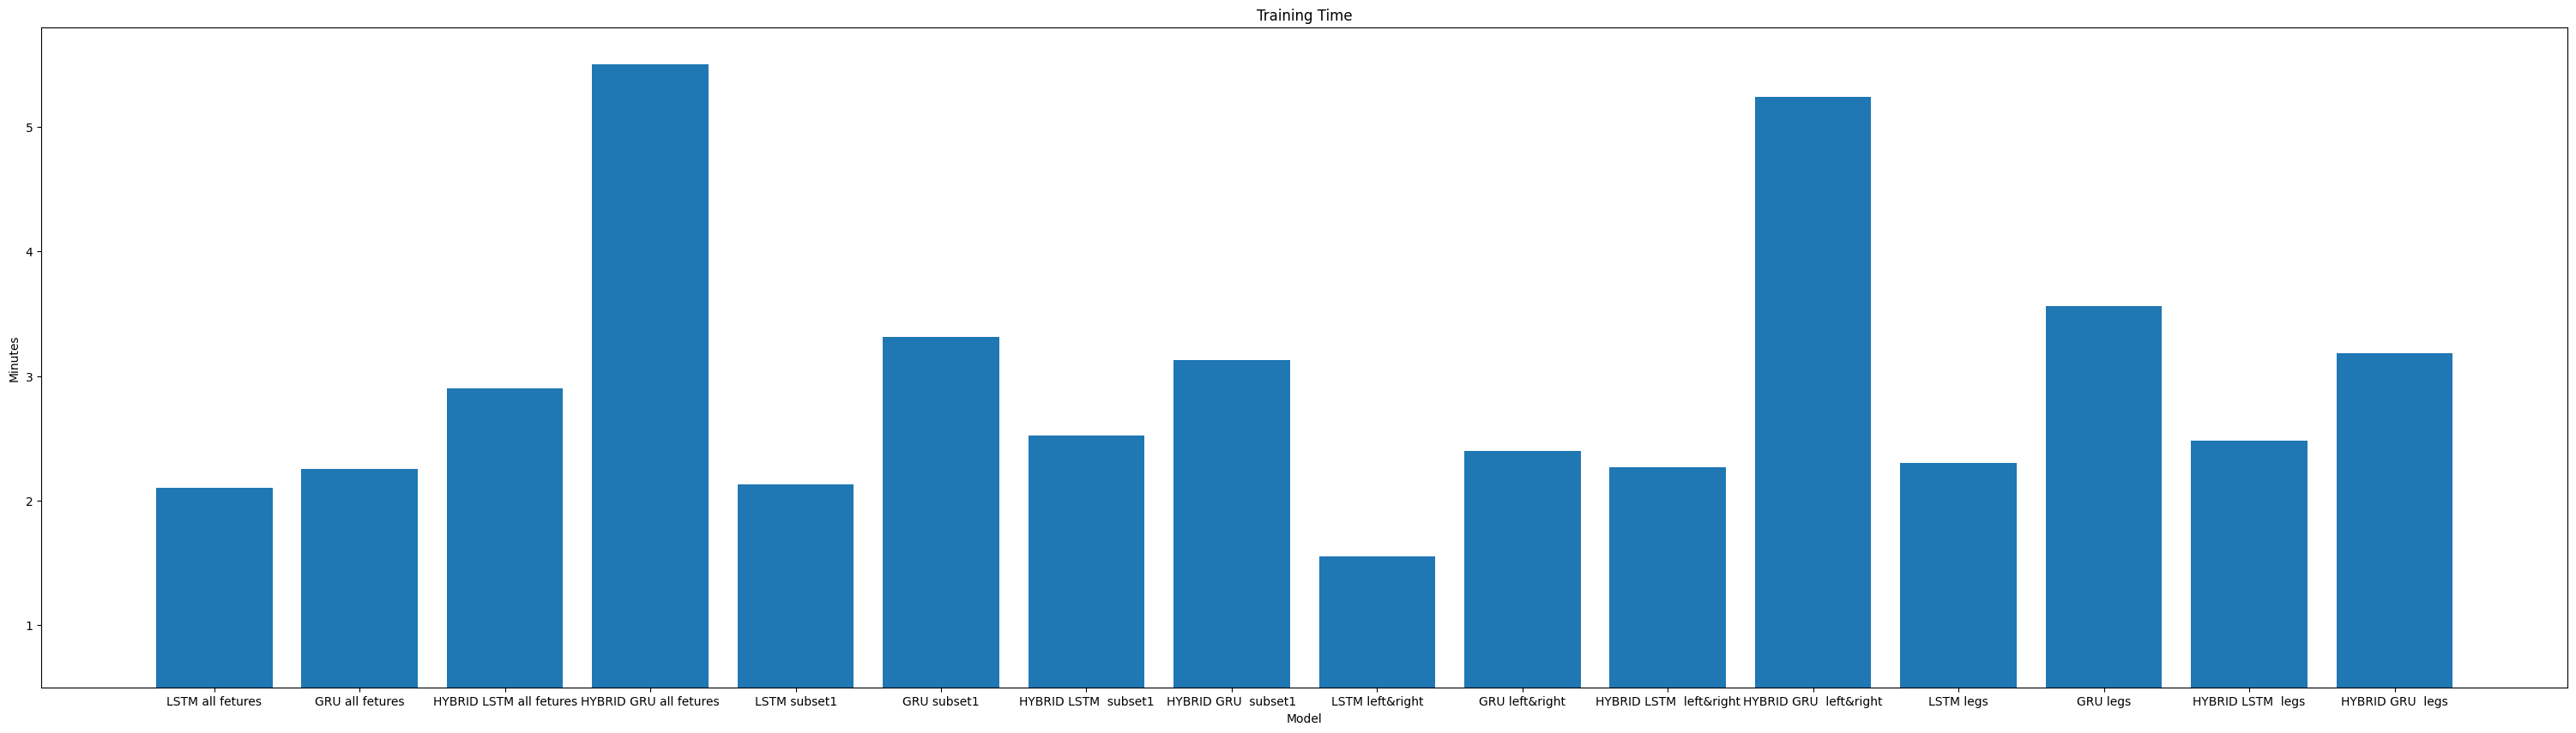

In [ ]:
label = ["LSTM all fetures","GRU all fetures","HYBRID LSTM all fetures","HYBRID GRU all fetures",
         "LSTM subset1","GRU subset1","HYBRID LSTM  subset1","HYBRID GRU  subset1",
         "LSTM left&right","GRU left&right","HYBRID LSTM  left&right","HYBRID GRU  left&right",
         "LSTM legs","GRU legs","HYBRID LSTM  legs","HYBRID GRU  legs"]


values = [float(".".join([str(j).split(".")[0] for j in [float(i) for i in str(l).split(":")[1:3]]])) for l in train_time]

fig = plt.subplots(figsize=(38,10))


plt.bar(label,values)
plt.title("Training Time")
plt.ylabel("Minutes")
plt.xlabel("Model")
plt.ylim(bottom=.5,top=5.8)
plt.show()

In [ ]:
temp={"Train time":values}
time_pd = pd.DataFrame(temp,index=label)
time_pd

,Train time
LSTM all fetures,2.10
GRU all fetures,2.25
HYBRID LSTM all fetures,2.90
HYBRID GRU all fetures,5.50
LSTM subset1,2.13
GRU subset1,3.31
HYBRID LSTM subset1,2.52
HYBRID GRU subset1,3.13
LSTM left&right,1.55
GRU left&right,2.40
